In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {c : i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i : c for c, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
block_size = 3

def build_dataset(words):
    X, y = [], []
    for w in words:
        context = [0] * block_size
        #print(w)
        for c in w + '.':
            X.append(context)
            y.append(stoi[c])
            context = context[1:] + [stoi[c]]
            #print(f"{''.join([itos[i] for i in context])} ==> {c}")
    #print("X:", X, "=>", " y:", y)
    X = torch.tensor(X)
    y = torch.tensor(y)
    print(X.shape, y.shape)
    return X, y


random.seed(2023)
random.shuffle(words)
n_train = int(0.8*len(words))
n_eval = int(0.9*len(words))

X_train, y_train = build_dataset(words[:n_train])
X_eval, y_eval = build_dataset(words[n_train:n_eval])
X_test, y_test = build_dataset(words[n_eval:])

torch.Size([182466, 3]) torch.Size([182466])
torch.Size([22839, 3]) torch.Size([22839])
torch.Size([22841, 3]) torch.Size([22841])


In [123]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
emb_len = 10
C = torch.randn((len(chars)+1, emb_len), generator=g) # 1 is '.'
hidden_layer_neuros = 200
W1 = torch.randn((block_size*emb_len, hidden_layer_neuros), generator=g)
b1 = torch.randn(hidden_layer_neuros, generator=g)
W2 = torch.randn((hidden_layer_neuros, len(chars)+1), generator=g) # need to calculate every char's probability, so the output dim shoulde be 27
b2 = torch.randn(len(chars)+1, generator=g)
parameters = [C, W1, b1, W2, b2]
print('W1.shape:', W1.shape)
print('b1.shape:', b1.shape)
print('W2.shape:', W2.shape)
print('b2.shape:', b2.shape)

W1.shape: torch.Size([30, 200])
b1.shape: torch.Size([200])
W2.shape: torch.Size([200, 27])
b2.shape: torch.Size([27])


In [124]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [125]:
for p in parameters:
    p.requires_grad = True

In [126]:
epochs = 200000
batch_size = 32

In [127]:
lre = torch.linspace(-3, 0, epochs)
lrs = 10**lre

In [128]:
lri = [] # learning rate
lossi = []
stepi = []

In [129]:
for i in range(epochs):
    # minbatch
    ix = torch.randint(0, X_train.shape[0], (batch_size, )) # random select batch_size indices
    
    # forward pass
    emb = C[X_train[ix]]
#     print('emb.shape:', emb.shape)
    h = torch.tanh(emb.view(-1, emb_len*block_size) @ W1 + b1)
#     print('h.shape:', h.shape)
    logits = h @ W2 + b2
#     print('logits.shape:', logits.shape)
    loss = F.cross_entropy(logits, y_train[ix])
#     counts = logits.exp()
#     probs = counts / counts.sum(1, keepdims=True)
#     loss = -probs[torch.arange(batch_size), y_train[ix]].log().mean() # negative log likelyhood
    #print(loss.item())
    
    # backward propagate
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update weights
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track states
    #lri.append(lr)
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
    #lossi.append(loss.item())
print(loss.item())

2.464416027069092


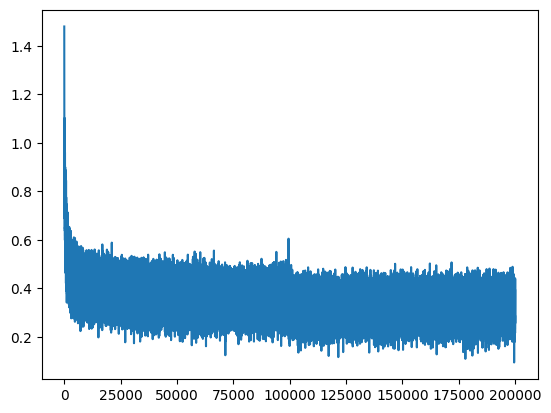

In [130]:
plt.plot(stepi, lossi)

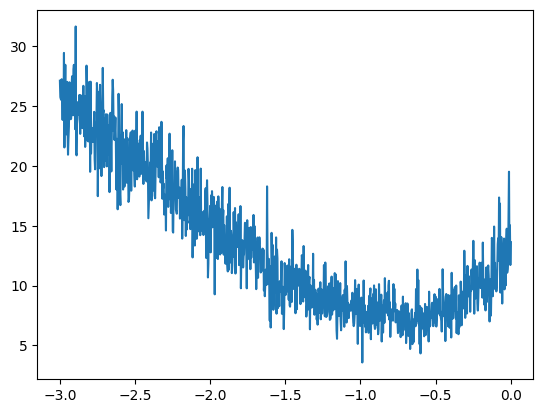

In [121]:
plt.plot(lri, lossi)

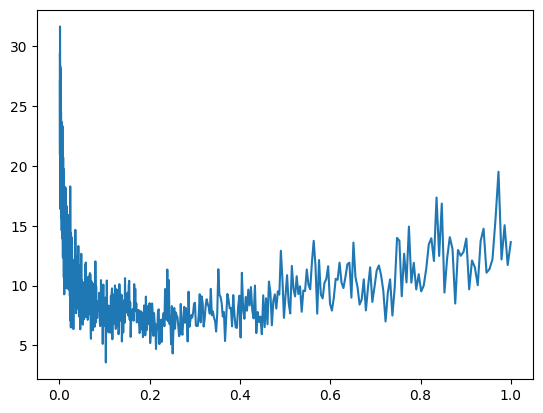

In [122]:
#plt.plot(lrs, lossi)

In [131]:
# training loss 
emb = C[X_train]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (batch_size, hidden_layer_neuros)
logits = h @ W2 + b2 # (hidden_layer_neuros, 27)
loss = F.cross_entropy(logits, y_train)
loss

tensor(2.1291, grad_fn=<NllLossBackward0>)

In [133]:
# validation loss 
emb = C[X_eval]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (batch_size, hidden_layer_neuros)
logits = h @ W2 + b2 # (hidden_layer_neuros, 27)
loss = F.cross_entropy(logits, y_eval)
loss

tensor(2.1832, grad_fn=<NllLossBackward0>)

In [134]:
# test loss 
emb = C[X_test]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (batch_size, hidden_layer_neuros)
logits = h @ W2 + b2 # (hidden_layer_neuros, 27)
loss = F.cross_entropy(logits, y_test)
loss

tensor(2.1813, grad_fn=<NllLossBackward0>)

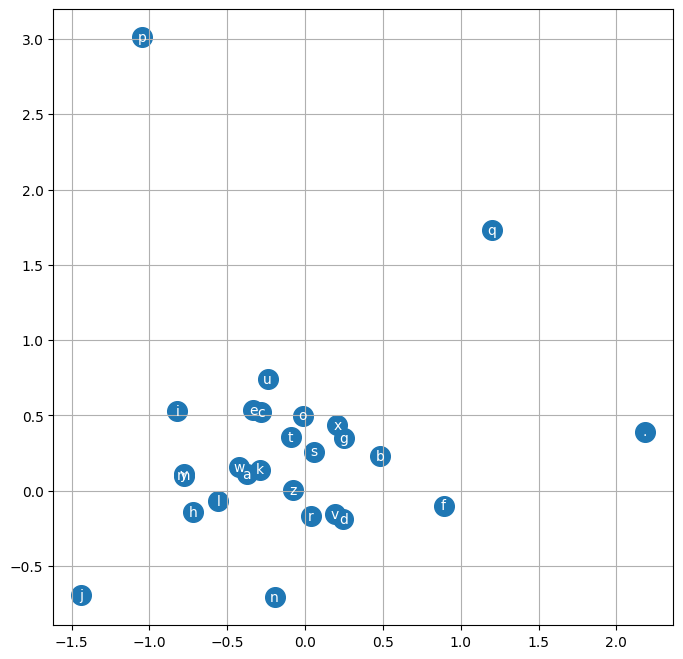

In [135]:
# visualization dimension 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize = (8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [139]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10) # for reproducibility

for _ in range(20):
    out = []
    context = [0] * block_size # init as all ....
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, emb_len)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carman.
quilli.
khi.
mili.
thaydencessa.
jazonel.
deliah.
jarqui.
nellara.
chaiiv.
kaleigh.
ham.
joct.
quintis.
lilah.
jadai.
wazell.
dearynix.
kaelynn.
demed.
